# HOME CREDIT SCORECARD MODEL
## FINAL PROJECT RAKAMIN PROJECT BASED INTERNSHIP

### BACKGROUND
Home Credit saat ini sedang menggunakan berbagai macam metode statistik dan Machine Learning untuk membuat prediksi skor kredit. Sekarang, kami meminta anda untuk membuka potensi maksimal dari data kami. Dengan melakukannya, kita dapat memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman, dan pinjaman datap diberikan dengan principal, maturity, dan repayment calendar yang akan memotivsi pelanggan untuk sukses.

#### Objective
- memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman 
- pinjaman dapat diberikan dengan principal, maturity, dan repayment calendar 
- Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

### IMPORT LIBRARY

In [23]:
# standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter('ignore')
import gc

# keras libraries
import tensorflow
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.metrics import Precision
from tqdm.keras import TqdmCallback
from keras.backend import clear_session

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

### EDA

READ DATA

In [24]:
df = pd.read_csv('../Dataset/application_train.csv')
df_column_desc = pd.read_csv('../Dataset/HomeCredit_columns_description.csv', encoding='latin-1')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


DESCRIBE

In [25]:
# Checknull
df.info()
print(df.isnull().sum())

# Print the count of columns
num_columns = df.shape[1]
print(f"Number of columns: {num_columns}")

# Print the count of rows
num_rows = df.shape[0]
print(f"Number of rows: {num_rows}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
Number of columns: 122
Number of rows: 307511


In [26]:
Column_Train = df_column_desc[df_column_desc['Table'] == 'application_{train|test}.csv']
column_train = Column_Train[['Row','Description']]
column_train

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...


In [50]:
#Unique Of Each Column
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print()

Unique values in column 'TARGET':
[1 0]

Unique values in column 'NAME_CONTRACT_TYPE':
['Cash loans' 'Revolving loans']

Unique values in column 'CODE_GENDER':
['M' 'F' 'XNA']

Unique values in column 'FLAG_OWN_CAR':
['N' 'Y']

Unique values in column 'FLAG_OWN_REALTY':
['Y' 'N']

Unique values in column 'CNT_CHILDREN':
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]

Unique values in column 'AMT_INCOME_TOTAL':
[202500.  270000.   67500.  ...  96768.  546250.5 113062.5]

Unique values in column 'AMT_CREDIT':
[ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]

Unique values in column 'AMT_ANNUITY':
[24700.5 35698.5  6750.  ... 71986.5 58770.  77809.5]

Unique values in column 'AMT_GOODS_PRICE':
[ 351000.  1129500.   135000.  ...  453465.   143977.5  743863.5]

Unique values in column 'NAME_TYPE_SUITE':
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']

Unique values in column 'NAME_INCOME_TYPE':
['Working' 'State servant' 'C

From that column desc, we can drop some column that not needed for modelling, before we use cmap.


In [27]:
df.drop('SK_ID_CURR', axis=1, inplace=True)

DATA VISUALIZATION

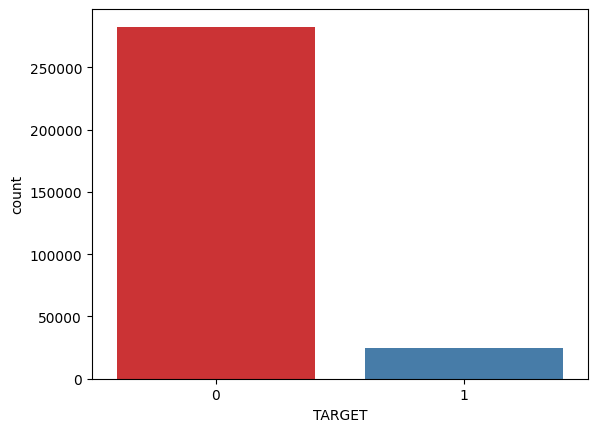

Gender Counts:
0    282686
1     24825
Name: TARGET, dtype: int64


In [40]:
sns.countplot(x='TARGET',data=df,palette='Set1')
plt.show()
targetcounts = df['TARGET'].value_counts()

# Display the counts
print("Target Counts:")
print(targetcounts)

Gender Counts:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


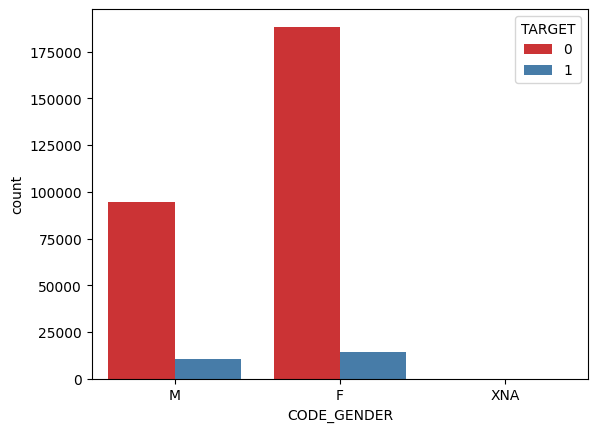

In [29]:
sns.countplot(data=df, x='CODE_GENDER', hue='TARGET', palette='Set1')
# Count occurrences of each gender
gender_counts = df['CODE_GENDER'].value_counts()

# Display the counts
print("Gender Counts:")
print(gender_counts)

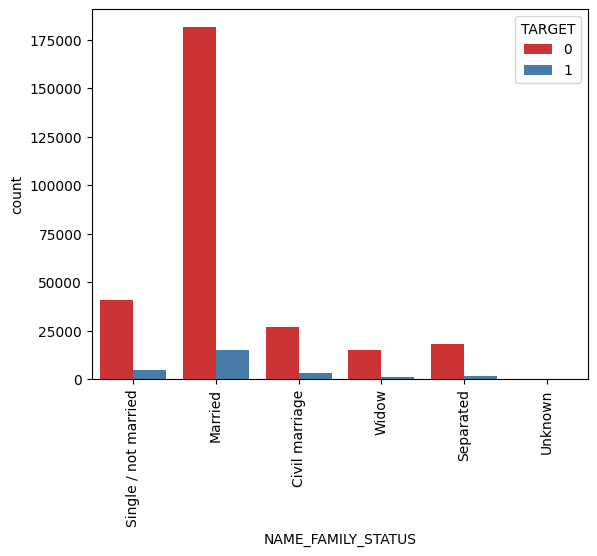

Gender Counts:
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64


In [36]:
sns.countplot(data=df, x='NAME_FAMILY_STATUS', hue='TARGET', palette='Set1')
plt.xticks(rotation=90)
plt.show()
statusf_count = df['NAME_FAMILY_STATUS'].value_counts()
# Display the counts
print("Gender Counts:")
print(statusf_count)

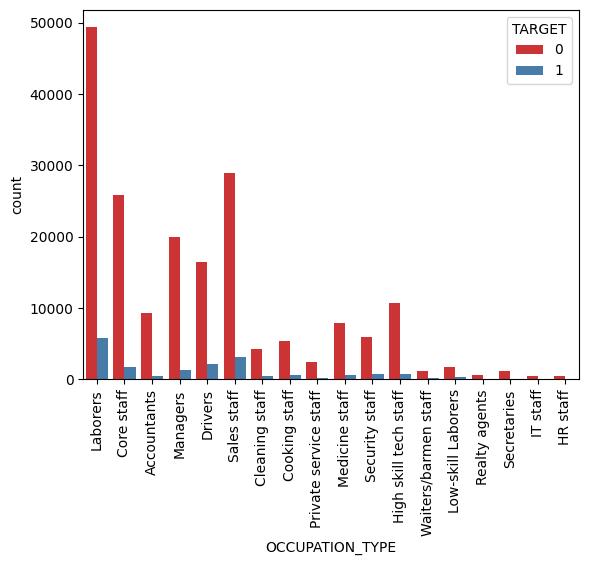

In [39]:
sns.countplot(x='OCCUPATION_TYPE',hue='TARGET',data=df,palette='Set1')
plt.xticks(rotation=90)
plt.show()

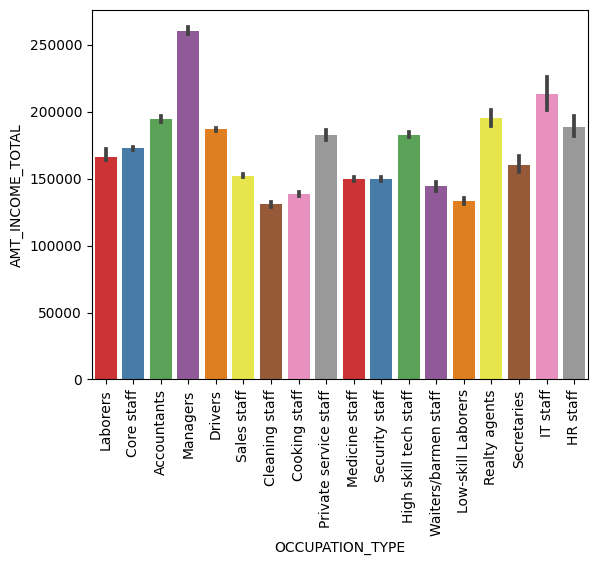

In [48]:
sns.barplot(x='OCCUPATION_TYPE',y='AMT_INCOME_TOTAL',data=df,palette='Set1')
plt.xticks(rotation=90)
plt.show()

### PREPROCESSING

#### FUCTION

In [32]:
#code here
# handling
# outlier
def outlier(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3-Q1
  df_final = df[~((df<(Q1-(1.5*IQR))) | (df>(Q3+(1.5*IQR))))]
  return df_final

sc = StandardScaler()